In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import theoretic as th
from sklearn.mixture import GaussianMixture
import anndata as ad
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from matplotlib.patches import Patch

In [3]:
base = "/data_nfs"
data = os.path.join(base, "datasets/melc/melanoma/")
fovs = os.listdir(os.path.join(data, "processed"))

In [4]:
antibody_gene_symbols = {
    'ADAM10': 'ADAM10',
    'Bcl-2': 'BCL2',
    'CD10': 'MME',
    'CD107a': 'LAMP1',
    'CD13': 'ANPEP',
    'CD138': 'SDC1',
    'CD14': 'CD14',
    'CD1a': 'CD1A',
    'CD2': 'CD2',
    'CD25': 'IL2RA',
    'CD271': 'NGFR',
    'CD3': ['CD3D', 'CD3E', 'CD3G'],
    'CD36': 'CD36',
    'CD4': 'CD4',
    'CD44': 'CD44',
    'CD45': 'PTPRC',
    'CD45RA': 'CD45RA/PTPRC',
    'CD45RO': 'CD45RO/PTPRC',
    'CD5': 'CD5',
    'CD56': 'NCAM1',
    'CD6': 'CD6',
    'CD63': 'CD63',
    'CD66abce': ['CEACAM1', 'CEACAM8', 'CEACAM6', 'CEACAM5'],
    'CD7': 'CD7',
    'CD71': 'TFRC',
    'CD8': ['CD8A', 'CD8B'],
    'CD9': 'CD9',
    'CD95': 'FAS',
    'Collagen IV': ['COL4A1', 'COL4A2'],
    'Cytokeratin-14': 'KRT14',
    'EBF-P': 'EBF1',
    'EGFR': 'EGFR',
    'EGFR-AF488': 'EGFR',
    'HLA-ABC': ['HLA-A', 'HLA-B', 'HLA-C'],
    'HLA-DR': ['HLA-DRA', 'HLA-DRB1', 'HLA-DRB5', 'NFX1'],
    'KIP1': 'CDKN1B',
    'Ki67': 'MKI67',
    'L302': 'NCR3LG1',
    'MCSP': 'CSPG4',
    'Melan-A': 'MLANA',
    'Nestin-AF488': 'NES',
    'Notch-1': 'NOTCH1',
    'Notch-3': 'NOTCH3',
    'PPARgamma': 'PPARG',
    'PPB': 'PPB?',
    'RIM3': 'RIMS3',
    'TAP73': 'TP73',
    'Vimentin': 'VIM',
    'p63': 'TP63',
    'phospho-Connexin': 'GJA1'
}

In [5]:
try:
    adata = ad.read_h5ad("adata_THEORETIC.h5ad")
except:
    x = pickle.load(open('/data_nfs/datasets/melc/melanoma/segmented/anndata_files/adata_cell.pickle', 'rb'))
    dfs = list()
    coords = dict()
    for k in x:
        anndata = x[k]
        raw_df = pd.DataFrame(anndata.X, columns=anndata.var["gene_symbol"])
        df = pd.DataFrame()
        
        for c in raw_df.columns:
            if c in ["CD45RA", "CD45RO", "PPB", 'CD66abce']:
                continue
            symbol = antibody_gene_symbols[c]
            if isinstance(symbol, list):
                for s in symbol:
                    df[s] = raw_df[c]
            else:
                df[symbol] = raw_df[c]
        
        df["fov"] = anndata.obsm["field_of_view"]
        df["condition"] = anndata.obsm["Group"]
    
        fov = np.unique(df["fov"])[0]
        if fov in ['Melanoma_29_202006031146_1', 'Melanoma_29_202006031146_2',
           'Melanoma_29_202006031146_3', 'Melanoma_29_202006031146_4',
                 'Nevi_01_201712121140_1', 'Nevi_01_201712121140_2',
                 'Melanoma_35_202009031055_1', 'Melanoma_35_202009031055_2',
           'Melanoma_35_202009031055_3', 'Melanoma_35_202009031055_4']:
            continue
        dfs.append(df) 
        coords[fov] = (x[k].uns["cell_coordinates"])
    
    
    
    df = pd.concat(dfs, ignore_index=True)
    df = df.dropna(axis="columns")
    
    adata = ad.AnnData(df.drop(["fov", "condition"], axis="columns"))
    adata.vars = list(df.drop(["fov", "condition"], axis="columns").columns)
    adata.var_names = list(df.drop(["fov", "condition"], axis="columns").columns)
    adata.obs["field_of_view"] = list(df["fov"].astype(str))
    adata.obs["condition"] = list(df["condition"].astype(str))
    adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]    
    #adata.uns["cell_coordinates"] = coords
    #sc.pp.neighbors(adata)
    #sc.tl.umap(adata)
    #sc.tl.pca(adata)

In [6]:
try:
    reference = pd.read_csv("skin_reference.csv", index_col="Unnamed: 0")
except:
    reference = th.get_hpa_reference('skin')
    usable_genes = [c for c in reference.columns if c in adata.var_names]
    reference = reference[usable_genes]

In [7]:
quality_dict = np.load(os.path.join(base, "je30bery/melanoma_data/qualtiy_assessment/quality.npy"), allow_pickle=True).item()
k = np.array(list(quality_dict.keys()))
v = np.array(list(quality_dict.values()))
high_quality = k[np.where(v == "2")]

In [8]:
adata = adata[adata.obs["field_of_view"].isin(high_quality)]

In [9]:
np.unique(adata.obs["field_of_view"])

array(['Melanoma_02_201802161126_1', 'Melanoma_02_201802161126_4',
       'Melanoma_07_201905161343_2', 'Melanoma_08_201905241311_1',
       'Melanoma_08_201905241311_2', 'Melanoma_09_201905291344_2',
       'Melanoma_10_201905291345_2', 'Melanoma_10_201905291345_3',
       'Melanoma_10_201905291345_4', 'Melanoma_11_201906261422_1',
       'Melanoma_12_201907031137_2', 'Melanoma_13_201907111415_1',
       'Melanoma_13_201907111415_2', 'Melanoma_13_201907111415_3',
       'Melanoma_13_201907111415_4', 'Melanoma_14_201907111432_1',
       'Melanoma_14_201907111432_2', 'Melanoma_14_201907111432_3',
       'Melanoma_14_201907111432_4', 'Melanoma_16_201908011518_1',
       'Melanoma_16_201908011518_4', 'Melanoma_17_201909111532_1',
       'Melanoma_17_201909111532_3', 'Melanoma_17_201909111532_4',
       'Melanoma_18_201909111536_1', 'Melanoma_18_201909111536_2',
       'Melanoma_18_201909111536_3', 'Melanoma_18_201909111536_4',
       'Melanoma_19_201910151344_1', 'Melanoma_19_201910151344

In [10]:
cell_types = sorted(list(reference.index))
pal = sns.color_palette("hls", len(np.unique(cell_types)))
cell_type_colors = {ct: pal[i] for i, ct in enumerate(cell_types)}

In [20]:
samples = dict()
all_cells = list()

for hq in high_quality:
    samples[hq] = adata[adata.obs["field_of_view"] == hq].copy()
    if len(samples[hq]) == 0:
        del samples[hq]

for hq in samples.keys():
    if "Nevi_03" in hq:
        continue
    tree = th.identify_cell_types(samples[hq], reference.copy(), min_fold_change=2, z_score_cutoff=1.96/4)
    #for st in tree.split_tuples:
    #    print(st.cell_type, st.mapped_genes)
    cell_types = list(samples[hq].obs["cell_type"])
    all_cells += cell_types
    p = os.path.join(base, "je30bery/melanoma_data/MAGICAL/data/cell_types", )
    with open(os.path.join(p, hq + "_cell_types.pkl"), "wb") as fp:   
        pickle.dump(cell_types, fp)

    #samples[hq].write_h5ad(f"./sample_wise_results/cell_types_{hq}.h5ad")
    plot = 0
    if plot:
        # for i in range(len(ROIS)):
        fov = hq
        segmented = os.path.join(data, "segmented", f'{fov}_cells.npy')
        with open(segmented, "rb") as openfile:
            seg_file = np.load(openfile)
            
        cell_types = samples[hq][samples[hq].obs["field_of_view"] == fov].obs["cell_type"]
        assert len(cell_types) > 0, "no cells found for this fov"
        assert len(np.unique(seg_file.flatten())) == len(cell_types) + 1
        
        cell_types_on_seg = np.zeros((seg_file.shape[0], seg_file.shape[1], 3))
        for i, cell in enumerate(np.unique(seg_file.flatten())):
            if cell == 0:
                continue
            cell_types_on_seg[np.where(seg_file == cell)] = cell_type_colors[cell_types[i - 1]]
        
        prop_iodide = cv2.imread([os.path.join(data, "processed", fov, f) for f in os.listdir(os.path.join(data, "processed", fov)) if "propidium" in f.lower()][0])
        
        plt.figure(figsize=(10,10))
        plt.imshow(cv2.addWeighted(prop_iodide, 0.4, (cell_types_on_seg * 255).astype(np.uint8), 0.6, 0))
        legend_handles = [Patch(color=color, label=key) for key, color in cell_type_colors.items()]
        
        # Create a dummy plot to show the legend
        plt.scatter([], [], label='Legend', alpha=0)  # Create an invisible point for the legend
        plt.legend(handles=legend_handles, loc=(1.01, 0.7))
        plt.title(fov)
    
        plt.tight_layout()
        plt.axis("off")
        plt.savefig(f"./examples/cell_type_analysis_{fov}_cells.png")
        #plt.show()

double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG']
double ['PPARG

In [24]:
df = pd.DataFrame(sorted(all_cells), columns=["cell_type"])

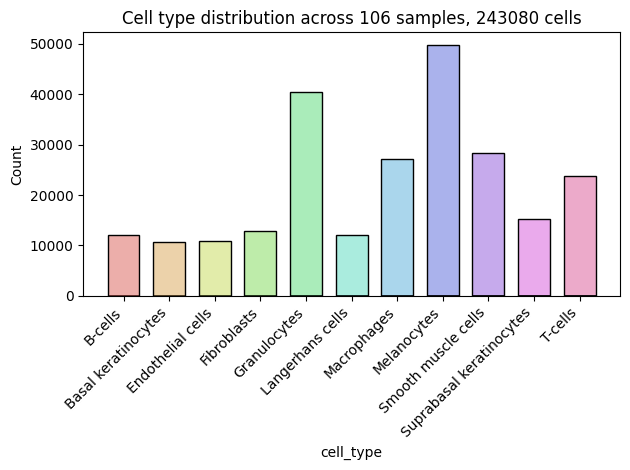

In [34]:
sns.histplot(df, x="cell_type", hue="cell_type", palette=cell_type_colors, shrink=0.7)
plt.xticks(rotation=45, ha="right")
plt.title(f"Cell type distribution across {len(samples)} samples, {len(all_cells)} cells")
plt.tight_layout()
plt.legend('', frameon=False)
plt.savefig("../result_plots/cell_types.pdf")